# Notebook: 02_Preprocessing_Before_Augmented_Lokal.ipynb

## Pengaturan Awal (Dilakukan di Terminal)

Sebelum menjalankan kode di notebook, pastikan Anda menginstal semua library yang diperlukan melalui terminal VS Code (dengan lingkungan virtual yang sudah aktif). Ini menggantikan sel `!pip install`.

In [13]:
```bash
# Buka terminal di VS Code (Ctrl + `) dan jalankan:
.\.venv\Scripts\activate
pip install pandas emoji langdetect scikit-learn regex matplotlib seaborn wordcloud openpyxl
```

*(Catatan: `openpyxl` ditambahkan agar bisa menyimpan file ke format `.xlsx`)*

SyntaxError: invalid syntax (1834946384.py, line 1)

## Import Library & Pengaturan Awal

Di sel pertama notebook, kita akan mengimpor semua library dan melakukan pengaturan dasar seperti logging dan membuat folder output.

## Memuat Dataset dari File Lokal

Bagian ini adalah pengganti utama dari `files.upload()`. Kita akan memuat file CSV langsung dari folder `data` di proyek Anda.

In [ ]:
# Cell 1: Import Library
import pandas as pd
import re
import emoji
import string
import logging
import os
from langdetect import detect, LangDetectException
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as dates

In [ ]:
# Cell 2: Inisialisasi Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [ ]:
# Cell 3: Buat folder untuk menyimpan output jika belum ada
# Ini adalah praktik yang baik untuk menjaga kerapian proyek
os.makedirs('data', exist_ok=True)
os.makedirs('images', exist_ok=True)
logger.info("Folder 'data' dan 'images' siap digunakan.")

2025-10-23 16:38:47,843 - INFO - Folder 'data' dan 'images' siap digunakan.


In [ ]:
# Cell 4: Memuat dataset dari folder lokal
try:
    # Memuat file hasil scraping yang dihasilkan oleh notebook 01.Scrap_Gojek.ipynb
    filename = 'data/Hasil_Scraping_Gojek.csv'
    df = pd.read_csv(filename)
    logger.info(f"Dataset {filename} dimuat dengan {len(df)} baris.")

    # Selaraskan nama kolom agar konsisten dengan pipeline preprocessing
    # Scraper menghasilkan kolom 'title' dan 'url'
    rename_map = {}
    if 'title' in df.columns and 'judul' not in df.columns:
        rename_map['title'] = 'judul'
    if 'url' in df.columns and 'link' not in df.columns:
        rename_map['url'] = 'link'
    if rename_map:
        df.rename(columns=rename_map, inplace=True)
        logger.info(f"Kolom di-rename: {rename_map}")
except FileNotFoundError:
    logger.error(f"File '{filename}' tidak ditemukan. Pastikan file tersebut ada di dalam folder 'data'.")
    df = pd.DataFrame() # Buat DataFrame kosong agar sisa kode tidak error


2025-10-23 16:38:56,100 - INFO - Dataset data/Hasil_Scraping_Gojek.csv dimuat dengan 103 baris.
2025-10-23 16:38:56,102 - INFO - Kolom di-rename: {'title': 'judul', 'url': 'link'}


In [ ]:
# Cell 5: Validasi kolom awal
if not df.empty:
    required_columns = ['judul', 'content', 'published_date']
    # Sesuaikan 'tanggal' menjadi 'published_date' agar cocok dengan output scraper sebelumnya
    if not all(col in df.columns for col in required_columns):
        missing_cols = [col for col in required_columns if col not in df.columns]
        logger.error(f"Kolom yang hilang: {missing_cols}")
        raise ValueError(f"DataFrame harus memiliki kolom: {required_columns}")

In [ ]:
# Cell 6: Konfigurasi variabel dan pola
if not df.empty:
    initial_count = len(df)
    # Sesuaikan akronim dan kata kunci ini dengan topik Gojek Anda
    important_acronyms = ['GOTO', 'UMKM', 'Gojek', 'GoFood', 'GoPay']
    gojek_keywords = ['gojek', 'goto', 'ojol', 'driver', 'aplikasi', 'layanan', 'tarif', 'gofood', 'gopay', 'transportasi']
    
    # Kamus normalisasi bisa Anda sesuaikan atau tambahkan
    normalization_dict = {
        'ga': 'tidak', 'nggak': 'tidak', 'gak': 'tidak', 'tdk': 'tidak',
        'yg': 'yang', 'dgn': 'dengan', 'utk': 'untuk', 'dr': 'dari',
        'go-jek': 'Gojek', 'go-food': 'GoFood', 'go-pay': 'GoPay'
    }
    
    # Pola Regex untuk membersihkan teks boilerplate dari berita (bisa ditambahkan)
    patterns_to_remove = [
        r'baca juga:.*', r'lihat juga:.*', r'artikel ini telah tayang.*',
        r'jakarta, cnn indonesia —.*', r'jakarta, kompas.com -.*'
    ]

    # Frasa spesifik yang ingin dihapus apa adanya (opsional, bisa dikosongkan)
    texts_to_remove = []

In [ ]:
# Fungsi preprocessing terintegrasi
def preprocess_text(text):
    try:
        # Standarisasi akronim
        for acronym in important_acronyms:
            text = re.sub(rf'(?i)\b{acronym}\b', acronym, str(text))

        # Hapus emoji dan karakter khusus
        text = emoji.replace_emoji(text, replace='')
        text = re.sub(r'[^\w\s.,!?éê]', '', text)

        # Normalisasi teks
        for slang, formal in normalization_dict.items():
            text = re.sub(rf'\b{slang}\b', formal, text, flags=re.IGNORECASE)
        text = re.sub(r',(?!\s)', ', ', text)
        text = text.replace('\\t', ' ').replace('\\n', ' ').replace('\\u', ' ').replace('\\', '')
        text = re.sub(r'(?i)(?:https?:\/\/)?(?:www\.)?(?:[a-zA-Z0-9-.]+)(?:\.[a-zA-Z]{2,6})(?:\/[^\s\r\n]*)?|(bit\.ly|tinyurl\.com|t\.co)\/[^\s\r\n]*', '', text)
        text = re.sub(r'\b\d{1,3}\b(?!\s*(?:miliar|triliun|hektar|tahun))', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation.replace(',', '').replace('.', '')))
        text = re.sub(r'\s+', ' ', text).strip()

        # Hapus teks tidak relevan
        for pattern in patterns_to_remove:
            text = re.sub(pattern, '', text)
        for text_to_remove in texts_to_remove:
            text = text.replace(text_to_remove, '')

        # Lowercasing dengan pengecualian
        for acronym in important_acronyms:
            text = re.sub(rf'\b{acronym}\b', f'__{acronym}__', text, flags=re.IGNORECASE)
        text = text.lower()
        for acronym in important_acronyms:
            text = text.replace(f'__{acronym}__', acronym)

        return text
    except Exception as e:
        logger.error(f"Error in preprocess_text: {e}")
        return text

In [ ]:
# Cell 8: Fungsi deteksi bahasa dan relevansi
def is_valid_text(text):
    try:
        is_id = detect(text) == 'id'
        keyword_count = sum(1 for keyword in gojek_keywords if keyword.lower() in text.lower())
        return is_id and keyword_count >= 2
    except LangDetectException:
        keyword_count = sum(1 for keyword in gojek_keywords if keyword.lower() in text.lower())
        return keyword_count >= 2
    except Exception as e:
        logger.error(f"Error in is_valid_text: {e}")
        return False

In [ ]:
# Cell 9: Fungsi hapus duplikasi berdasarkan konten
def remove_duplicates(df_to_clean):
    try:
        vectorizer = TfidfVectorizer(max_features=5000)
        tfidf_matrix = vectorizer.fit_transform(df_to_clean['cleaned_content'].fillna(''))
        cosine_sim = cosine_similarity(tfidf_matrix)
        indices_to_remove = set()
        for i in range(len(cosine_sim)):
            for j in range(i + 1, len(cosine_sim)):
                if cosine_sim[i][j] > 0.9: # Threshold kesamaan 90%
                    indices_to_remove.add(j)
        return df_to_clean.drop(index=list(indices_to_remove)).reset_index(drop=True)
    except Exception as e:
        logger.error(f"Error in remove_duplicates: {e}")
        return df_to_clean

In [ ]:
# Cell 10: Proses preprocessing utama
if not df.empty:
    logger.info("Memulai preprocessing...")
    # Pastikan kolom published_date bertipe datetime (data dari scraper sudah dalam format ISO)
    # Gunakan utc=True untuk konsistensi timezone
    df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce', utc=True)

    # Pastikan kolom content tersedia (hasil scraper)
    df = df.dropna(subset=['content']).copy()

    logger.info("Menerapkan pembersihan pada teks...")
    df['cleaned_content'] = df['content'].apply(preprocess_text)
    # Judul dapat berasal dari kolom 'judul' (hasil rename dari 'title')
    title_col = 'judul' if 'judul' in df.columns else ('title' if 'title' in df.columns else None)
    if title_col:
        df['cleaned_title'] = df[title_col].apply(preprocess_text)

    logger.info("Menghapus duplikasi berdasarkan konten...")
    df = remove_duplicates(df)
    logger.info(f"Jumlah data setelah menghapus duplikasi: {len(df)}")

    logger.info("Memfilter teks berdasarkan bahasa dan relevansi...")
    df = df[df['cleaned_content'].apply(is_valid_text)].reset_index(drop=True)
    logger.info(f"Jumlah data setelah filter: {len(df)}")

    logger.info("Melakukan analisis tambahan...")
    df['tahun'] = df['published_date'].dt.year
    berita_per_tahun = df['tahun'].value_counts().sort_index()
    logger.info("Distribusi berita per tahun:\n" + berita_per_tahun.to_string())

2025-10-23 16:39:30,476 - INFO - Memulai preprocessing...
C:\Users\malvi\AppData\Local\Temp\ipykernel_26684\2886928016.py:5: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S%z format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce', dayfirst=True, utc=True)
2025-10-23 16:39:30,542 - INFO - Menerapkan pembersihan pada teks...
2025-10-23 16:39:31,536 - INFO - Menghapus duplikasi berdasarkan konten...
2025-10-23 16:39:31,632 - INFO - Jumlah data setelah menghapus duplikasi: 103
2025-10-23 16:39:31,634 - INFO - Memfilter teks berdasarkan bahasa dan relevansi...
2025-10-23 16:39:34,847 - INFO - Jumlah data setelah filter: 97
2025-10-23 16:39:34,849 - INFO - Melakukan analisis tambahan...
2025-10-23 16:39:34,860 - INFO - Distribusi berita per tahun:
tahun
2018.0     2
2021.0     1
2022.0     5
2023.0     2
2024.0     5
2025.0    17


2025-10-23 16:45:56,532 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-10-23 16:45:56,546 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


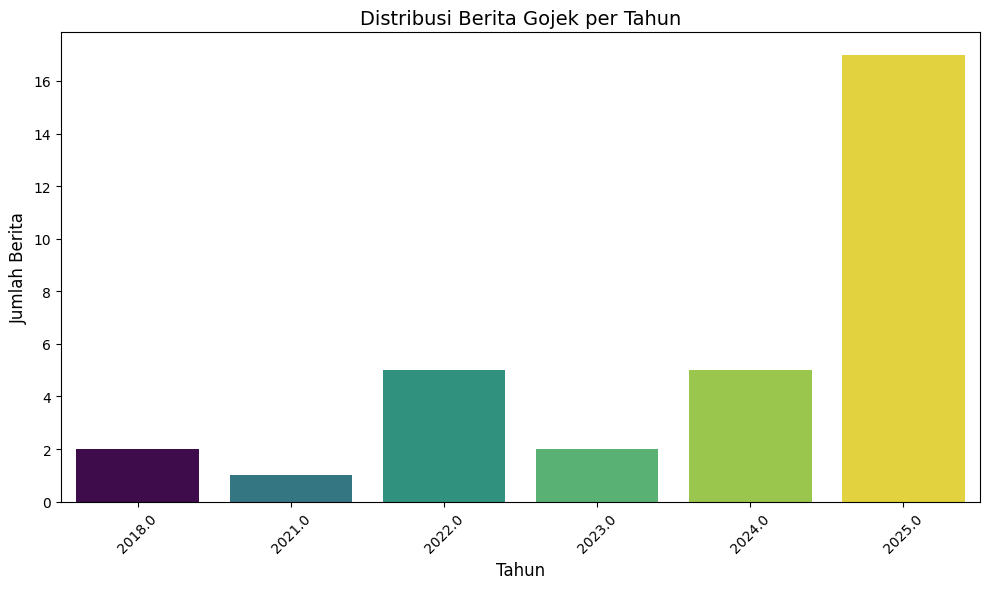

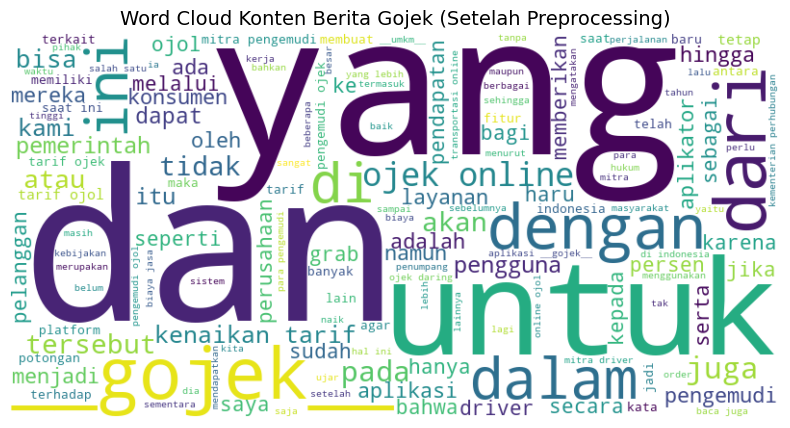

2025-10-23 16:45:58,772 - INFO - Data disimpan ke data/gojek_news_preprocessed.csv dan .xlsx
2025-10-23 16:45:58,774 - INFO - Jumlah data akhir: 97 (dari awal 103)
2025-10-23 16:45:58,775 - INFO - Sampel 5 baris pertama setelah preprocessing:


,cleaned_title,cleaned_content,published_date
0,"tarif ojol naik persen, pakar transportasi ing...",yogyakarta pemerintah melalui kementerian perh...,2025-07-24 22:49:04+00:00
1,__gojek__ siap kaji perubahan tarif ojek onlin...,__gojek__ siap kaji perubahan tarif ojek onlin...,NaT
2,"kenaikan tarif ojol sarat risiko, pemerintah p...",rised menilai penerapan kenaikan tarif ojol di...,2025-07-01 08:07:28+00:00
3,__gojek__ pastikan ikuti kebijakan kenaikan ta...,"rakyat news, jakarta induk perusahaan __gojek_...",2025-07-02 02:06:15+00:00
4,mengatur potongan aplikasi ojek online. fakta ...,"hari ini, mei 2025 ojek online melakukan aksi ...",NaT


In [14]:
# Cell 11: Visualisasi dan Simpan Hasil
if not df.empty:
    # Visualisasi Distribusi per Tahun
    plt.figure(figsize=(10, 6))
    # Menambahkan 'hue' untuk menghindari warning di versi seaborn mendatang
    sns.barplot(x=berita_per_tahun.index, y=berita_per_tahun.values, palette='viridis', hue=berita_per_tahun.index, legend=False)
    plt.title('Distribusi Berita Gojek per Tahun', fontsize=14)
    plt.xlabel('Tahun', fontsize=12)
    plt.ylabel('Jumlah Berita', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('images/berita_gojek_per_tahun.png') # Simpan ke folder images
    plt.show()

    # Word Cloud
    wordcloud_text = ' '.join(df['cleaned_content'].dropna())
    if wordcloud_text:
        wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(wordcloud_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud Konten Berita Gojek (Setelah Preprocessing)', fontsize=14)
        plt.savefig('images/wordcloud_gojek.png') # Simpan ke folder images
        plt.show()

    # Simpan hasil ke file CSV dan Excel di folder 'data'
    output_filename = 'data/gojek_news_preprocessed'
    
    # Untuk Excel, hapus timezone info dari published_date
    df_for_excel = df.copy()
    if 'published_date' in df_for_excel.columns:
        # Konversi timezone-aware datetime ke timezone-naive
        df_for_excel['published_date'] = df_for_excel['published_date'].dt.tz_localize(None)
    
    # Simpan CSV terlebih dahulu
    df.to_csv(f'{output_filename}.csv', index=False)
    
    # Simpan Excel dengan DataFrame yang sudah di-convert
    df_for_excel.to_excel(f'{output_filename}.xlsx', index=False)
    logger.info(f"Data disimpan ke {output_filename}.csv dan .xlsx")
    logger.info(f"Jumlah data akhir: {len(df)} (dari awal {initial_count})")

    # Tampilkan sampel
    logger.info("Sampel 5 baris pertama setelah preprocessing:")
    display(df[['cleaned_title', 'cleaned_content', 'published_date']].head())